In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import operator

In [2]:
# Especifica los nombres de las columnas o déjalos como None si no tienen encabezados
columnas = ['Source', 'Target', '']  # Puedes cambiar estos nombres

In [3]:
Network=pd.read_csv('GS_MT.csv',header=None, names=columnas)
Network.head()

Source   Target   
0  Rv0001   Rv0001  1
1  Rv0001   Rv0002  1
2  Rv0001   Rv0003  1
3  Rv0001  Rv3396c  1
4  Rv0001  Rv3411c  1

In [4]:
Net=nx.from_pandas_edgelist(Network, 'Source', 'Target', edge_attr=True, create_using=nx.DiGraph)

In [5]:
print(Net)

DiGraph with 1624 nodes and 3212 edges


In [6]:
Net2=Net.to_undirected()

<h2>Componentes conexas

In [7]:
NumCC=nx.number_connected_components(Net2)
print("Number of connected components:", NumCC)

Number of connected components: 6


In [8]:
[len(c) for c in sorted(nx.connected_components(Net2), key=len, reverse=True)]

[1604, 6, 5, 4, 3, 2]

In [9]:
#Diametro
largest_cc = max(nx.connected_components(Net2), key=len)
subgraph=Net2.subgraph(largest_cc)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 8


In [10]:
#
Clust=nx.clustering(Net)

/home/eduardo/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_9472/4157208765.py:19: RuntimeWarning: divide by zero encountered in log
  yfit = lambda x: np.exp(poly(np.log(x)))
/home/eduardo/anaconda3/lib/python3.11/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


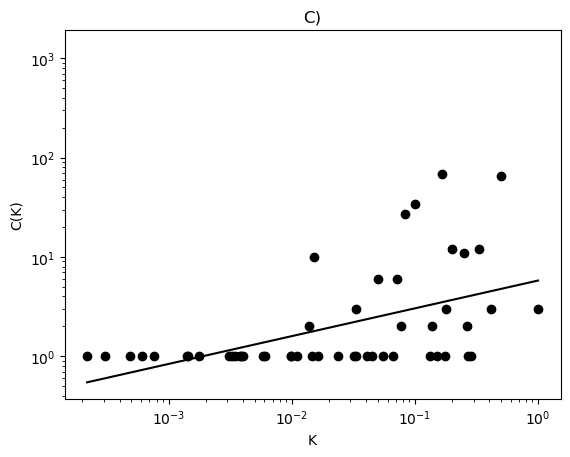

In [11]:
comp=[]
for value in Clust.values():
    comp.append(value)

values, counts = np.unique(comp, return_counts=True)
dfCC = pd.DataFrame({'xCC': values, 'yCC': counts}, columns=['xCC', 'yCC'])
x=dfCC[['xCC']].to_numpy()
y=dfCC[['yCC']].to_numpy()

x.astype(float);
y.astype(float);
dflog=np.log(dfCC[['xCC','yCC']])
new_df = dflog.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

logx = new_df.xCC
logy = new_df.yCC
coeffs = np.polyfit(logx,logy,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))

plt.loglog(x,y,'ko')
plt.ylabel('C(K)')
plt.xlabel('K')
plt.title('C)')
plt.loglog(x,yfit(x),'k')
#plt.legend()
#interactive(False)

# Guardar la figura como PNG
plt.savefig('GS-clustering.png', dpi=300)
plt.show()

In [12]:
M = nx.adjacency_matrix(Net, nodelist=sorted(Net.nodes()))

/tmp/ipykernel_13504/1411984368.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(Net, nodelist=sorted(Net.nodes()))


In [13]:
indegrees = np.asarray(M.sum(axis=0)).flatten()  # Sumar por columnas (ejes verticales)
outdegrees = np.asarray(M.sum(axis=1)).flatten()  # Sumar por filas (ejes horizontales)

indegrees = indegrees.astype(np.int64)
outdegrees = outdegrees.astype(np.int64)

In [14]:
indegree_distribution = np.bincount(indegrees)
outdegree_distribution = np.bincount(outdegrees)

In [15]:
xdata = np.array(range(len(indegree_distribution)))
ydata = np.array(indegree_distribution)

dataset = pd.DataFrame({'xdata': xdata, 'ydata': ydata}, columns=['xdata', 'ydata'])
dataset = dataset[~(dataset == 0).any(axis=1)]
dataset.head()

xdata  ydata
1      1    895
2      2    353
3      3    143
4      4     77
5      5     48

In [16]:
x=dataset.xdata.tolist()
y=dataset.ydata.tolist()
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)
yerr = 0.2 * y   
logx = np.log10(x)
logy = np.log10(y)
logyerr = yerr / y

In [17]:
from scipy import optimize

fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print (pfinal)
print (covar)

[ 3.12939632 -2.24293599]
[[ 0.02158098 -0.02584303]
 [-0.02584303  0.03721747]]


In [18]:
index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

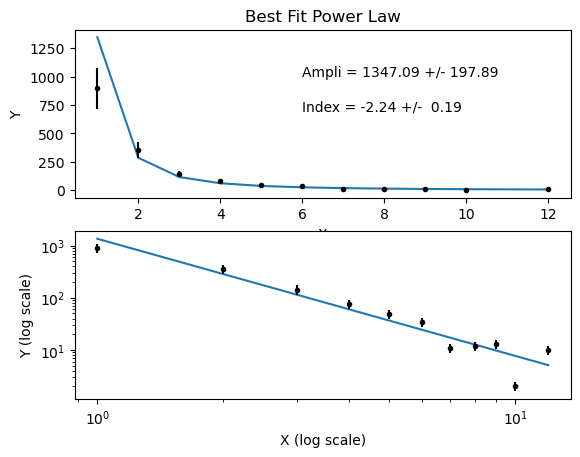

In [19]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.errorbar(x, y, yerr=yerr, fmt='k.')  # Data
plt.text(6, 1000, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(6, 700, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(2, 1, 2)
plt.loglog(x, powerlaw(x, amp, index))
plt.errorbar(x, y, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')

# Guardar la figura como PNG
plt.savefig('GS-indegree.png', dpi=300)
plt.show()

In [20]:
Indegree_dict = dict(Net.in_degree(Net.nodes()))
nx.set_node_attributes(Net, Indegree_dict, 'degree')
sorted_Indegree = sorted(Indegree_dict.items(), key=operator.itemgetter(1), reverse=True)

In [21]:
dfKin = pd.DataFrame(sorted_Indegree, columns =['Node', 'Kin'])
dfKin.head(10)

Node  Kin
0  Rv2930   12
1  Rv2931   12
2  Rv2932   12
3  Rv2933   12
4  Rv2934   12
5  Rv2935   12
6  Rv2936   12
7  Rv2937   12
8  Rv2938   12
9  Rv2939   12

In [22]:
xdata = np.array(range(len(outdegree_distribution)))
ydata = np.array(outdegree_distribution)

dataset = pd.DataFrame({'xdata': xdata, 'ydata': ydata}, columns=['xdata', 'ydata'])
dataset = dataset[~(dataset == 0).any(axis=1)]

In [23]:
x=dataset.xdata.tolist()
y=dataset.ydata.tolist()
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)
yerr = 0.2 * y   
logx = np.log10(x)
logy = np.log10(y)
logyerr = yerr / y

In [24]:
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print (pfinal)
print (covar)

[ 0.79988885 -0.38775236]
[[ 0.00686167 -0.00387227]
 [-0.00387227  0.00256919]]


In [25]:
index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

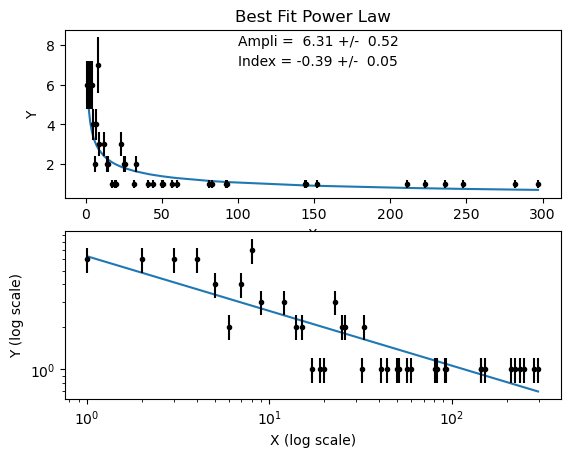

In [26]:
powerlaw = lambda x, amp, index: amp * (x**index)
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.errorbar(x, y, yerr=yerr, fmt='k.')  # Data
plt.text(100, 8, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(100, 7, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(2, 1, 2)
plt.loglog(x, powerlaw(x, amp, index))
plt.errorbar(x, y, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')

# Guardar la figura como PNG
plt.savefig('GS-outdegree.png', dpi=300)
plt.show()

In [27]:
Outdegree_dict = dict(Net.out_degree(Net.nodes()))
nx.set_node_attributes(Net, Outdegree_dict, 'degree')
sorted_Outdegree = sorted(Outdegree_dict.items(), key=operator.itemgetter(1), reverse=True)

In [28]:
dfKout = pd.DataFrame(sorted_Outdegree, columns =['Node', 'Kout'])
dfKout.head(10)

Node  Kout
0   Rv0348   297
1   Rv1221   282
2   Rv0757   248
3   Rv3676   236
4   Rv0491   223
5   Rv0981   211
6  Rv3286c   152
7   Rv2711   145
8   Rv2710   144
9  Rv3291c    93